# Interpretability
## Some tools: https://towardsdatascience.com/interpretable-machine-learning-1dec0f2f3e6b

When to scale: https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e, KNN and PCA need scaling, while Trees don't.
For future work on data: https://towardsdatascience.com/dimensionality-reduction-does-pca-really-improve-classification-outcome-6e9ba21f0a32

In [70]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../data/SAMPLE_SUBMISSION.CSV
../data/starcraft-2-player-prediction-challenge-2019.zip
../data/submission.csv
../data/TEST.CSV
../data/TEST_LONG.CSV
../data/TRAIN.CSV
../data/TRAIN_LONG.CSV


In [71]:
import csv
from collections import defaultdict
csv_file = '../data/TRAIN.CSV'
with open(csv_file, newline='') as csv_text:
    cvs_reader = csv.reader(csv_text, delimiter=',')
    data = []
    ids = []
    
    for row in cvs_reader:
        
        csv_dict = defaultdict(int)
        csv_dict['id'] = row[0]
        ids.append(row[0])
        csv_dict['class'] = row[1]
        t = 0
        for i in range(1, len(row)-2):
            if 'hotkey' in row[len(row)-i] and t != 0:
                csv_dict[row[len(row)-i][:-1]] += 1/t
                
            if 'Base' in row[len(row)-i] and t != 0:
                csv_dict['base'] += 1/t
            
            if 'Mineral' in row[len(row)-i] and t != 0:
                csv_dict['mineral'] += 1/t
                
            if 's' == row[len(row)-i] and t != 0:
                csv_dict['s'] += 1/t
                
            if 't' in row[len(row)-i][0] and t==0:
                t = int(row[len(row)-i][1:])
        data.append(csv_dict)

In [72]:
print(data[0], data[80])

defaultdict(<class 'int'>, {'id': 'http://eu.battle.net/sc2/en/profile/4234852/1/First/', 'class': 'Protoss', 'hotkey6': 0.012688821752265853, 'hotkey5': 0.07129909365558913, 'hotkey4': 0.15709969788519723, 'hotkey3': 0.24290030211480534, 's': 0.40725075528701243, 'hotkey1': 0.24954682779456372, 'hotkey2': 0.1341389728096683, 'hotkey0': 0.027794561933534714, 'base': 0.03927492447129905, 'hotkey9': 0.002416918429003021, 'mineral': 0.0030211480362537764, 'hotkey7': 0.0006042296072507553}) defaultdict(<class 'int'>, {'id': 'http://eu.battle.net/sc2/en/profile/251061/1/LiveZerg/', 'class': 'Zerg', 'hotkey1': 0.36326530612244756, 's': 1.0517006802721012, 'hotkey4': 0.5768707482993151, 'base': 0.010884353741496598, 'hotkey2': 0.04081632653061224, 'hotkey3': 0.005442176870748299})


In [73]:
#To be sure that we get all the right keys
csv_keys = ['id', 'class', 'base', 's', 'mineral']
for i in range(10):
    csv_keys.append('hotkey' + str(i))
print(csv_keys)

['id', 'class', 'base', 's', 'mineral', 'hotkey0', 'hotkey1', 'hotkey2', 'hotkey3', 'hotkey4', 'hotkey5', 'hotkey6', 'hotkey7', 'hotkey8', 'hotkey9']


In [74]:
print(len(data))
print(len(ids))

3052
3052


In [75]:
#Only for visualization purposes
df = pd.DataFrame(data, columns=csv_keys) 
df.head().fillna(0)

,id,class,base,s,mineral,hotkey0,hotkey1,hotkey2,hotkey3,hotkey4,hotkey5,hotkey6,hotkey7,hotkey8,hotkey9
0,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,0.039275,0.407251,0.003021,0.027795,0.249547,0.134139,0.242900,0.157100,0.071299,0.012689,0.000604,0.000000,0.002417
1,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,0.007251,0.324471,0.000000,0.051360,0.311178,0.138973,0.210876,0.187915,0.000000,0.000000,0.000000,0.010272,0.011480
2,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,0.045545,0.425743,0.002970,0.020792,0.145545,0.133663,0.317822,0.135644,0.090099,0.011881,0.000000,0.000000,0.003960
3,http://eu.battle.net/sc2/en/profile/3074362/1/...,Protoss,0.019900,0.395025,0.000000,0.039801,0.289552,0.083582,0.249751,0.284577,0.000000,0.000000,0.000000,0.000000,0.014925
4,http://eu.battle.net/sc2/en/profile/4234852/1/...,Protoss,0.001852,0.385185,0.000000,0.001852,0.114815,0.081481,0.372222,0.159259,0.027778,0.000000,0.000000,0.000000,0.000000


# Stratify Sampling

Cleaning data

In [76]:
#Define map class->value
CLASSES = {}

#Zerg -> 0
#Protoss -> 1
#Terran -> 2
CLASSES['Zerg'] = 0
CLASSES['Protoss'] = 1
CLASSES['Terran'] = 2

In [77]:
#Separate Labels from features
features = []

for sample in data:
    dict_temp = {}
    #New dictionary without the label
    for key, value in sample.items():
        if key != 'id':
            #Change classes names into numbers
            if key == 'class':
                value = CLASSES[value]
            dict_temp[key] = value
    #Append to features list
    features.append(dict_temp)
print(features[0], features[19])    

{'class': 1, 'hotkey6': 0.012688821752265853, 'hotkey5': 0.07129909365558913, 'hotkey4': 0.15709969788519723, 'hotkey3': 0.24290030211480534, 's': 0.40725075528701243, 'hotkey1': 0.24954682779456372, 'hotkey2': 0.1341389728096683, 'hotkey0': 0.027794561933534714, 'base': 0.03927492447129905, 'hotkey9': 0.002416918429003021, 'mineral': 0.0030211480362537764, 'hotkey7': 0.0006042296072507553} {'class': 0, 's': 1.1153846153846116, 'hotkey1': 0.3880341880341868, 'hotkey4': 0.4401709401709388, 'hotkey2': 0.17264957264957217, 'hotkey5': 0.01367521367521368, 'base': 0.012820512820512825, 'hotkey3': 0.03247863247863249}


Split

In [78]:
from sklearn.model_selection import train_test_split

df_X = pd.DataFrame(features, columns=csv_keys) 
X = df_X.fillna(0).values
y = np.asarray(ids)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=ids)

*Test if we have correct distribution*

In [79]:
counter = 0

for i in y_valid:
    if i not in y_train:
        counter += 1

print(counter)

0


# KNN

Following the tutorial at: https://towardsdatascience.com/knn-using-scikit-learn-c6bed765be75

In [88]:
#Import the KNeighborsCLassifier class from sklearn
from sklearn.neighbors import KNeighborsClassifier

#Import metrics model to check the accuracy
from sklearn import metrics
#Try running from k=1 through 25 and record testing accuracy
k_range = range(1, 5)
scores = {}
scores_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_valid)
    scores[k] = metrics.accuracy_score(y_valid, y_pred)
    scores_list.append(scores[k])

In [ ]:
#Visualize K vs Accuracy

Text(0, 0.5, 'Validation Accuracy')

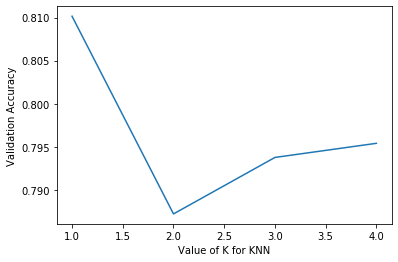

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt

#Plot relationship between K and accuracy
plt.plot(k_range, scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Validation Accuracy')

**Final model with k=3**

In [15]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [16]:
#Open TEST file and prepare TEST data
csv_file = '../data/TEST.CSV'
with open(csv_file, newline='') as csv_text:
    test_reader = csv.reader(csv_text, delimiter=',')
    test_data = []
    
    for row in test_reader:
        
        test_dict = defaultdict(int)
        test_dict['class'] = CLASSES[row[0]] #On prend deja le numero
        t = 0
        for i in range(1, len(row)-1):
            if 'hotkey' in row[len(row)-i] and t != 0:
                test_dict[row[len(row)-i][:-1]] += 1/t
            if 't' in row[len(row)-i][0] and t==0:
                t = int(row[len(row)-i][1:])
        test_data.append(test_dict)
    print(test_data[0])

defaultdict(<class 'int'>, {'class': 0, 'hotkey6': 1.1234285714285597, 'hotkey1': 0.4400000000000036, 'hotkey0': 0.9817142857142777, 'hotkey2': 0.08799999999999987, 'hotkey9': 0.03999999999999999, 'hotkey7': 0.053714285714285666, 'hotkey3': 0.005714285714285715})


In [17]:
#Testing
df_testX = pd.DataFrame(test_data, columns=csv_keys) 
X_test = df_testX.fillna(0).values

y_predict = knn.predict(X_test)

In [18]:
#Save predictions
predictions_formatted = []

for i, value in enumerate(y_predict, 1):
    predictions_formatted.append([i, value])

df_predict = pd.DataFrame(predictions_formatted)
df_predict.head()

,0,1
0,1,http://eu.battle.net/sc2/en/profile/3538115/1/...
1,2,http://eu.battle.net/sc2/en/profile/2896854/1/...
2,3,http://eu.battle.net/sc2/en/profile/3973341/1/...
3,4,http://eu.battle.net/sc2/en/profile/250458/1/V...
4,5,http://eu.battle.net/sc2/en/profile/950504/1/G...


In [19]:
import os
#Remove if exists
submission_path = '../data/submission.csv'
if os.path.exists(submission_path):
    os.remove(submission_path)
df_predict.to_csv(submission_path, header=['RowId','prediction'], mode='w', index=False)

# RNN
C'est parallelizable et on peut donner des poids et détecter des outliers

In [20]:
#Load libraries
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [67]:
#Train a radius neighbors classifier
#rnn = RadiusNeighborsClassifier(radius = 0.5, n_jobs = -1).fit(X_std, y_valid)

#Import metrics model to check the accuracy
from sklearn import metrics
#Try running from r=0.5 through 10 with a step of 0.5 and record testing accuracy
step = 0.25
r_range = range(17)
scores = {}
scores_list = []
for r in r_range:
    rnn = RadiusNeighborsClassifier(radius = (r*step), n_jobs = 1)
    rnn.fit(X_train, y_train)
    try:
        y_pred = rnn.predict(X_valid)
    except ValueError:
        y_pred = []
        for _ in range(len(y_valid)):
            y_pred.append('null')
    scores[r] = metrics.accuracy_score(y_valid, y_pred)
    scores_list.append(scores[r])

Text(0, 0.5, 'Validation Accuracy')

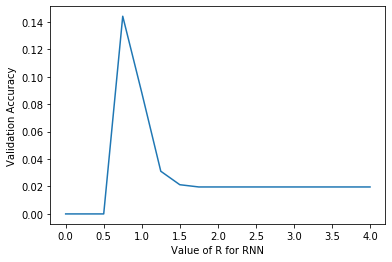

In [68]:
#Visualize R vs Accuracy
%matplotlib inline
import matplotlib.pyplot as plt

#Plot relationship between R and accuracy
a = [item*step for item in r_range]
plt.plot(a, scores_list)
plt.xlabel('Value of R for RNN')
plt.ylabel('Validation Accuracy')